# ENDG 511 Project: Classifying Cassava Plants 
By: Matthew Ocando & Daphne Hong

In [1]:
!pip install -q tensorflow-model-optimization

# import statements
import tensorflow as tf
import tempfile
import os
import time
import pickle
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow_model_optimization as tfmot
from keras.utils.layer_utils import count_params

In [2]:
# mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# map disease code to disease name
label_map = {"0": "Cassava Bacterial Blight (CBB)", 
          "1": "Cassava Brown Streak Disease (CBSD)", 
          "2": "Cassava Green Mottle (CGM)", 
          "3": "Cassava Mosaic Disease (CMD)", 
          "4": "Healthy"}

In [4]:
# load in labels from csv
data = pd.read_csv('/content/gdrive/MyDrive/ENDG511-Project/train.csv') 
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [5]:
# count the number of different labels in the dataset
data['label'].value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

*train.csv* is a csv file that includes 2 columns:

*   *image_id* : name of image in dataset
*   *label* : disease code that maps to a disease name

Disease code 3 (Cassava Mosaic Disease) dominates over the other classes. There are similar amounts of data samples for disease codes 4, 2, and 1 (Healthy, Cassava Green Mottle, and Cassava Brown Streak Disease respectively) and few data samples for disease code 0 (Cassava Bacterial Blight).

Due to the unequal representation of each class, the machine learning model may be biased towards disease code 3 in its prediction.



In [6]:
# extract files from cassava-leaf-disease-classification.zip
from zipfile import ZipFile
file_name = '/content/gdrive/MyDrive/ENDG511-Project/cassava-leaf-disease-classification.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


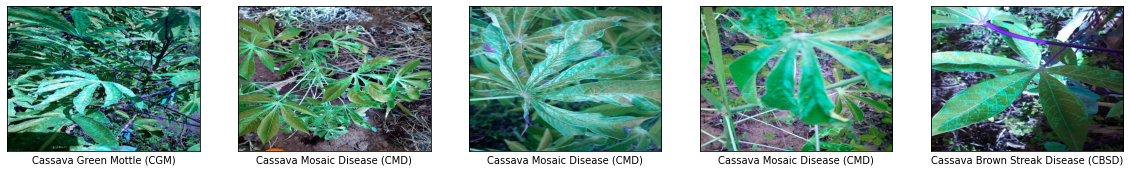

In [7]:
# check training images
plt.rcParams["figure.figsize"] = (20,20)
fig, ax = plt.subplots(1,5)
n=0
for col in ax:
  n=n+100
  img = cv2.imread('/content/train_images/'+data['image_id'][n], cv2.IMREAD_UNCHANGED)
  col.imshow(img)
  col.set_xticks([])
  col.set_yticks([])
  col.set_xlabel(label_map.get(str(data['label'][n])))
plt.show()


In [8]:
# check for missing values
data.isna().sum()

image_id    0
label       0
dtype: int64

No values are missing, so no additional data cleaning is required.

In [9]:
# convert labels to strings for Image Data Generator
data.label = data.label.astype(str)

# split data into training and testing sets - use 80/20 ratio
train_images, test_images = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=0)

In [10]:
# initialize the Image Data Generator class - data augmentation
ImageFlow = tf.keras.preprocessing.image.ImageDataGenerator(rescale= 1/255.0,
                                                            rotation_range=20,
                                                            zoom_range=0.05,
                                                            width_shift_range=0.05,
                                                            height_shift_range=0.05,
                                                            shear_range=0.05,
                                                            horizontal_flip=True)

# initialize training generator
IG_train = ImageFlow.flow_from_dataframe(train_images,directory='/content/train_images/',x_col='image_id',
                                         y_col='label',batch_size=100,seed=30,target_size=(128,128))

# initialize testing generator
IG_test = ImageFlow.flow_from_dataframe(test_images,directory='/content/train_images/',x_col='image_id',
                                        y_col='label',batch_size=100,seed=30,target_size=(128,128))

Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


## Transfer Learning

Next, we will import MobileNet with weights pre-trained on the ImageNet dataset. The final fully-connected layer will not be transferred (include_top=False) since the classification problem in this project has a different number of classes than the data in ImageNet.

Since it is easier to manage the Keras Sequential Model class (as opposed to Functional Model class), we will also move these weights over to said model type.

In [11]:
# Load in MobileNetV1 with pre-trained weights on ImageNet
load_model = tf.keras.applications.MobileNet(
                  input_shape=IG_train.image_shape,
                  alpha=1.0,
                  include_top=False,
                  weights='imagenet',
                  input_tensor=None,
                  pooling='max',
                  classifier_activation='softmax'
              )

# Convert from functional to sequential model
base_model = tf.keras.models.Sequential()
for layer in load_model.layers:
  base_model.add(layer)

# Need to add an output (dense) layer with random weights since include_top=False
base_model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Print model summary
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 64, 64, 32)        0

Now, we create a model with the same architecture as MobileNetV1, but initialized with random weights instead.

In [12]:
load_model = tf.keras.applications.MobileNet(
                  input_shape=IG_train.image_shape,
                  alpha=1.0,
                  include_top=True,
                  weights=None,
                  input_tensor=None,
                  pooling='max',
                  classes=5,
                  classifier_activation='softmax'
              )

random_model = tf.keras.models.Sequential()
for layer in load_model.layers:
  random_model.add(layer)

random_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                          
                                                                 
 conv_dw_1_relu (ReLU)       (None, 64, 64, 32)       

The transfer_model() function defined below is responsible for transferring a varying number of layers from the pre-trained MobileNetV1.

In [13]:
def transfer_model(layerNum_list, base_model, random_model, batch_size=254, IG_train=None, IG_test=None, Trainable=False):
  
  # Empty dictionaries for saving each model's accuracies. 
  history={}
  y_pred={}
  time_={}
  evaluation={}
 
  # The core logic of AnB architecture 
  # Create a model in each out loop and evaluate it 
  for i in range(len(layerNum_list)):

    # Create a new sequential model
    model_new = models.Sequential()
    input_shape = (128, 128, 3) # NEW EDITS # 

    # Add the first layer with input shape
    model_new.add(layers.InputLayer(input_shape=input_shape)) # NEW EDITS # 

    # Create the base_model layers that are transferred
    base_model_layers = []
    for n in range(layerNum_list[i]-1, -len(base_model.layers)-1, -1):
      
      # Define whether transferred base layers are trainable or not
      base_model.layers[n].trainable = Trainable

      base_model_layers.append(base_model.get_layer(index = n))

    base_model_layers.reverse()

    # Create the model layers that are randomly initialized
    random_model_layers = []
    for n in range(-1,layerNum_list[i]-1,-1):
      random_model_layers.append(random_model.get_layer(index = n))
    random_model_layers.reverse()
    
    # Create the new model
    for layer in base_model_layers:
      model_new.add(layer)
    for layer in random_model_layers:
      model_new.add(layer)

    # Defining callbacks
    # Call back 1: 
    base_learning_rate = 0.001
    ES = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    # Call back 2: 
    RLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

    # Compiling each model
    model_new.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    # Training each model
    # Saving the iteration's output (accuracies) to use it at a later stage
    print('\n MODEL',i+1, 'TRAINING STARTED ... ')
    start_time = time.time()
    history[i] = model_new.fit(IG_train, batch_size=batch_size, epochs=1, validation_data=IG_test, callbacks=[ES,RLR])
    time_[i] = time.time() - start_time

    # Check trainable parameters
    trainable_count = count_params(model_new.trainable_weights)
    non_trainable_count = count_params(model_new.non_trainable_weights)
    print('Trainable Parameters:', trainable_count)
    print('Non-Trainable Parameters:', non_trainable_count, '\n')

    print('\n MODEL', i+1, 'TRAINING ENDED ... ')

    y_pred[i]=model_new.predict(IG_test,verbose=0)
    evaluation[i] = model_new.evaluate(IG_test,verbose=0)

  return history,time_,y_pred,evaluation  


The following approach involves splitting the model architecture into 13 sections and transferring certain portions at a time.

In [14]:
layers_list = [int(x) for x in np.linspace(-len(base_model.layers)+1, -9, 12)]

First, we will evaluate performance without fine tuning.

In [ ]:
history, time_, y_pred,evaluation = transfer_model(layers_list, base_model=base_model, random_model=random_model, batch_size=254, \
                                                               IG_train=IG_train, IG_test=IG_test, Trainable=False)


 MODEL 1 TRAINING STARTED ... 
172/172 [==============================] - 320s 2s/step - loss: 1.1391 - accuracy: 0.6162 - val_loss: 1.2006 - val_accuracy: 0.6150 - lr: 0.0010
Trainable Parameters: 3210885
Non-Trainable Parameters: 22688 


 MODEL 1 TRAINING ENDED ... 

 MODEL 2 TRAINING STARTED ... 
172/172 [==============================] - 281s 2s/step - loss: 0.9548 - accuracy: 0.6495 - val_loss: 2.1400 - val_accuracy: 0.1114 - lr: 0.0010
Trainable Parameters: 3208069
Non-Trainable Parameters: 25344 


 MODEL 2 TRAINING ENDED ... 

 MODEL 3 TRAINING STARTED ... 
172/172 [==============================] - 261s 1s/step - loss: 0.9866 - accuracy: 0.6444 - val_loss: 2.0242 - val_accuracy: 0.1114 - lr: 0.0010
Trainable Parameters: 3198085
Non-Trainable Parameters: 34240 


 MODEL 3 TRAINING ENDED ... 

 MODEL 4 TRAINING STARTED ... 
172/172 [==============================] - 273s 2s/step - loss: 0.8647 - accuracy: 0.6794 - val_loss: 2.4014 - val_accuracy: 0.2621 - lr: 0.0010
Trainable 

Save the training results to text files so that the model need not be re-trained every time the code is run.

In [ ]:
# Save results to text files
lists = [history,time_,y_pred,evaluation]
names = ['history','time_','y_pred','evaluation']

for i in range(4):
  file = open('/content/gdrive/MyDrive/ENDG511-Project/'+names[i]+'.txt','w')
  for key,value in lists[i].items():
    file.write(str(value)+"\n")
  file.close()

In [ ]:
# Load evaluation results from text files
evaluation={}

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'evaluation'+'.txt','r')
lines = file.readlines()
j=0
for l in lines:
  evaluation[j] = [float(x) for x in l.replace('\n','').replace('[','').replace(']','').split(',')]
  j+=1
file.close()

print(evaluation)

{0: [1.1759295463562012, 0.6341121792793274], 1: [1.7685049772262573, 0.26985982060432434], 2: [1.3912230730056763, 0.4427570104598999], 3: [0.8022976517677307, 0.7035046815872192], 4: [1.4846614599227905, 0.420560747385025], 5: [0.838046669960022, 0.6897196173667908], 6: [1.1023831367492676, 0.5334112048149109], 7: [0.8427167534828186, 0.6908878684043884], 8: [0.8113988041877747, 0.7028037309646606], 9: [0.8390499353408813, 0.6920560598373413], 10: [0.8185099959373474, 0.7053738236427307], 11: [0.8845352530479431, 0.6719626188278198]}


Next, we will allow fine tuning and evaluate performance.

In [ ]:
history_plus, time_plus, y_pred_plus, evaluation_plus = transfer_model(layers_list, base_model=base_model, random_model=random_model, batch_size=254, \
                                                               IG_train=IG_train, IG_test=IG_test, Trainable=True)


 MODEL 1 TRAINING STARTED ... 
172/172 [==============================] - 271s 1s/step - loss: 1.1370 - accuracy: 0.6128 - val_loss: 1.2042 - val_accuracy: 0.6150 - lr: 0.0010
Trainable Parameters: 3211749
Non-Trainable Parameters: 21824 


 MODEL 1 TRAINING ENDED ... 

 MODEL 2 TRAINING STARTED ... 
172/172 [==============================] - 258s 1s/step - loss: 0.9704 - accuracy: 0.6442 - val_loss: 1.3665 - val_accuracy: 0.6150 - lr: 0.0010
Trainable Parameters: 3211525
Non-Trainable Parameters: 21888 


 MODEL 2 TRAINING ENDED ... 

 MODEL 3 TRAINING STARTED ... 
172/172 [==============================] - 255s 1s/step - loss: 0.9582 - accuracy: 0.6489 - val_loss: 1.3628 - val_accuracy: 0.5673 - lr: 0.0010
Trainable Parameters: 3210693
Non-Trainable Parameters: 21632 


 MODEL 3 TRAINING ENDED ... 

 MODEL 4 TRAINING STARTED ... 
172/172 [==============================] - 253s 1s/step - loss: 0.8742 - accuracy: 0.6767 - val_loss: 2.2435 - val_accuracy: 0.1787 - lr: 0.0010
Trainable 

In [ ]:
# Save results to text files
lists = [history_plus,time_plus,y_pred_plus,evaluation_plus]
names = ['history_plus','time_plus','y_pred_plus','evaluation_plus']

for i in range(4):
  file = open('/content/gdrive/MyDrive/ENDG511-Project/'+names[i]+'.txt','w')
  for key,value in lists[i].items():
    file.write(str(value)+"\n")
  file.close()

In [ ]:
# Load evaluation results from text files
evaluation_plus={}

file = open('/content/gdrive/MyDrive/ENDG511-Project/'+'evaluation_plus'+'.txt','r')
lines = file.readlines()
j=0
for l in lines:
  evaluation_plus[j] = [float(x) for x in l.replace('\n','').replace('[','').replace(']','').split(',')]
  j+=1
file.close()

print(evaluation_plus)

{0: [1.2041643857955933, 0.6149532794952393], 1: [1.3665306568145752, 0.6149532794952393], 2: [1.3623461723327637, 0.5640186667442322], 3: [2.2446532249450684, 0.1787383109331131], 4: [1.2289708852767944, 0.5023364424705505], 5: [1.3557769060134888, 0.6852803826332092], 6: [0.7562323808670044, 0.7341121435165405], 7: [1.2773104906082153, 0.5158878564834595], 8: [2.2408323287963867, 0.3792056143283844], 9: [0.7237192988395691, 0.7621495127677917], 10: [1.3382648229599, 0.6156542301177979], 11: [1.6580073833465576, 0.5399532914161682]}


Finally, we will plot a graph showing the change in accuracy versus the number of transferred layers.

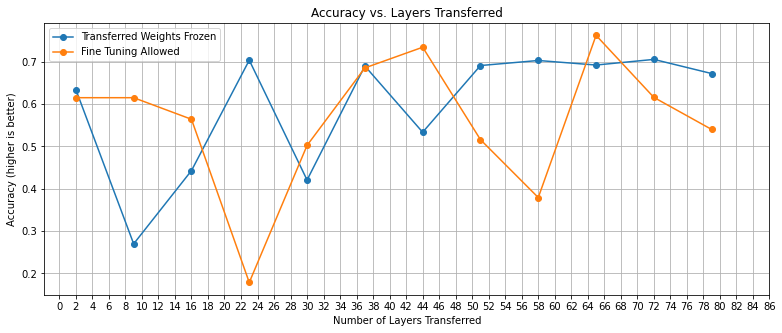

In [ ]:
# Plot accuracy versus number of transferred layers
plt.rcParams["figure.figsize"] = (13,5)
accuracies = []
accuracies_plus = []
layers_transferred = [len(base_model.layers)+1+x for x in layers_list]
for k,v in evaluation.items():
  accuracies.append(v[1])
for k,v in evaluation_plus.items():
  accuracies_plus.append(v[1])

plt.plot(layers_transferred,accuracies,label = 'Transferred Weights Frozen',marker='o')
plt.plot(layers_transferred,accuracies_plus,label = 'Fine Tuning Allowed',marker='o')
plt.xlabel('Number of Layers Transferred')
plt.ylabel('Accuracy (higher is better)')
plt.title('Accuracy vs. Layers Transferred')
plt.xticks(range(0,len(base_model.layers),2))
plt.grid()
plt.legend()
plt.show()

Observing the above trend, it would appear that transferring '65' trainable layers produces optimal accuracy results. As such, we will move forward using this model. We will retrain for 10 epochs.

In [ ]:
# Create a new sequential model
model_new = models.Sequential()
input_shape = (128, 128, 3) # NEW EDITS # 

# Add the first layer with input shape
model_new.add(layers.InputLayer(input_shape=input_shape)) # NEW EDITS # 

# Create the base_model layers that are transferred
base_model_layers = []
for n in range(-65-1, -len(base_model.layers)-1, -1):
     
  # Define whether transferred base layers are trainable or not
  base_model.layers[n].trainable = True

  base_model_layers.append(base_model.get_layer(index = n))

base_model_layers.reverse()

# Create the model layers that are randomly initialized
random_model_layers = []
for n in range(-1, -65-1, -1):
  random_model_layers.append(random_model.get_layer(index = n))
random_model_layers.reverse()
    
# Create the new model
for layer in base_model_layers:
  model_new.add(layer)
for layer in random_model_layers:
  model_new.add(layer)

# Defining callbacks
# Call back 1: 
base_learning_rate = 0.001
ES = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
# Call back 2: 
RLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# Compile the model
model_new.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
model_new.fit(IG_train,batch_size=254, epochs=10,validation_data=IG_test,callbacks=[ES,RLR])

Epoch 1/10
172/172 [==============================] - 249s 1s/step - loss: 0.6532 - accuracy: 0.7614 - val_loss: 1.0086 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 2/10
172/172 [==============================] - 237s 1s/step - loss: 0.5999 - accuracy: 0.7831 - val_loss: 0.9189 - val_accuracy: 0.6428 - lr: 0.0010
Epoch 3/10
172/172 [==============================] - 236s 1s/step - loss: 0.5725 - accuracy: 0.7920 - val_loss: 1.6111 - val_accuracy: 0.4755 - lr: 0.0010
Epoch 4/10
172/172 [==============================] - 236s 1s/step - loss: 0.5482 - accuracy: 0.8041 - val_loss: 0.6356 - val_accuracy: 0.7752 - lr: 0.0010
Epoch 5/10
172/172 [==============================] - 237s 1s/step - loss: 0.5316 - accuracy: 0.8087 - val_loss: 1.2355 - val_accuracy: 0.5876 - lr: 0.0010
Epoch 6/10
172/172 [==============================] - 237s 1s/step - loss: 0.5189 - accuracy: 0.8148 - val_loss: 0.9966 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 7/10
172/172 [==============================] - 237s 1s/st

In [10]:
############################################## TESTING ############################################################
# Create a new sequential model
model_new = models.Sequential()
input_shape = (128, 128, 3)

# Add the first layer with input shape
model_new.add(layers.InputLayer(input_shape=input_shape))

# Create the base_model layers that are transferred
base_model_layers = []
for n in range(-65-1, -len(base_model.layers)-1, -1):
     
  # Define whether transferred base layers are trainable or not
  base_model.layers[n].trainable = True

  base_model_layers.append(base_model.get_layer(index = n))

base_model_layers.reverse()

# Create the model layers that are randomly initialized
random_model_layers = []
for n in range(-1, -65-1, -1):
  random_model_layers.append(random_model.get_layer(index = n))
random_model_layers.reverse()
    
# Create the new model
for layer in base_model_layers:
  model_new.add(layer)
for layer in random_model_layers:
  model_new.add(layer)

# Defining callbacks
# Call back 1: 
base_learning_rate = 0.001
ES = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=6, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
# Call back 2: 
RLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=4, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# Compile the model
model_new.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# Train the model
model_new.fit(IG_train,batch_size=254, epochs=10,validation_data=IG_test,callbacks=[ES,RLR])

Epoch 1/10
172/172 [==============================] - 326s 2s/step - loss: 0.9893 - accuracy: 0.6412 - val_loss: 1.5917 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 2/10
172/172 [==============================] - 263s 2s/step - loss: 0.8593 - accuracy: 0.6781 - val_loss: 2.1643 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 3/10
172/172 [==============================] - 263s 2s/step - loss: 0.7919 - accuracy: 0.7036 - val_loss: 1.6803 - val_accuracy: 0.6145 - lr: 0.0010
Epoch 4/10
172/172 [==============================] - 297s 2s/step - loss: 0.7323 - accuracy: 0.7275 - val_loss: 1.0517 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 5/10
172/172 [==============================] - 263s 2s/step - loss: 0.6815 - accuracy: 0.7500 - val_loss: 1.4850 - val_accuracy: 0.4432 - lr: 0.0010
Epoch 6/10
172/172 [==============================] - 297s 2s/step - loss: 0.6480 - accuracy: 0.7600 - val_loss: 1.3763 - val_accuracy: 0.5037 - lr: 0.0010
Epoch 7/10
172/172 [==============================] - 264s 2s/st

In [ ]:
# Saving the whole model instead of just weights
!mkdir -p /content/drive/MyDrive/ENDG_511/saved_model
model_new.save('/content/gdrive/MyDrive/ENDG511-Project/saved_model/base_model')

In [ ]:
# Loading the saved model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/saved_model/base_model')

## Model Compression

Now, we will apply pruning and post-training quantization in differing amounts. This will demonstrate the effects of applying differing model compression techniques in cascade and will help to identify the best model.

In [14]:
############################################## TESTING ############################################################
pruned_80_model, stripped_pruned_80_model = pruning(model_new, 0.8)
prune_80_16_bit_model = quantization(stripped_pruned_80_model, 16)
with open('/content/gdrive/MyDrive/ENDG511-Project/testing', 'wb') as f:
  f.write(prune_80_16_bit_model)
interpreter_prune_80_16_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/testing')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/3
172/172 [==============================] - 301s 2s/step - loss: 0.6427 - accuracy: 0.7681 - val_loss: 1.8704 - val_accuracy: 0.1481
Epoch 2/3
172/172 [==============================] - 267s 2s/step - loss: 0.5990 - accuracy: 0.7832 - val_loss: 2.1324 - val_accuracy: 0.3136
Epoch 3/3
172/172 [==============================] - 299s 2s/step - loss: 0.5731 - accuracy: 0.7909 - val_loss: 1.0076 - val_accuracy: 0.6591


In [65]:
############################################## TESTING ############################################################
print(evaluate_model(interpreter_prune_80_16_bit))

4
1
4
4
0.5


In [11]:
# Define a function that applies pruning
def pruning(model, target_sparsity):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Prune the model with target sparsity indicated by element in 'target_sparsity'
  pruning_params = {'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity, begin_step=0, frequency=100)}
  pruned_model = prune_low_magnitude(model, **pruning_params)

  # Train model
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(), 
                metrics=['accuracy'])  
  pruned_model.fit(IG_train, epochs=3, validation_data=IG_test, 
                   callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])

  # Strip pruning wrappers
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  return pruned_model, stripped_pruned_model

In [12]:
# Define a function that applies post-training quantization
def quantization(model, quantization_level):

  # Convert to TFLite and apply quantization
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT] # Set default optimizer (8-bit quantization)
  converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
  ]
  if quantization_level == 16:
    converter.target_spec.supported_types = [tf.float16] # Apply 16-bit floating point quantization
  quantized_tflite_model = converter.convert()

  return quantized_tflite_model

In [ ]:
# Apply 10% pruning to base model
pruned_10_model, stripped_pruned_10_model = pruning(model, 0.1)

Epoch 1/3
172/172 [==============================] - 347s 2s/step - loss: 0.4954 - accuracy: 0.8224 - val_loss: 0.5644 - val_accuracy: 0.8023
Epoch 2/3
172/172 [==============================] - 291s 2s/step - loss: 0.4819 - accuracy: 0.8275 - val_loss: 0.6694 - val_accuracy: 0.7855
Epoch 3/3
172/172 [==============================] - 305s 2s/step - loss: 0.4733 - accuracy: 0.8329 - val_loss: 0.5338 - val_accuracy: 0.8140


In [ ]:
# Apply 30% pruning to base model
pruned_30_model, stripped_pruned_30_model = pruning(model, 0.3)

Epoch 1/3
172/172 [==============================] - 323s 2s/step - loss: 0.4704 - accuracy: 0.8323 - val_loss: 0.6978 - val_accuracy: 0.7472
Epoch 2/3
172/172 [==============================] - 321s 2s/step - loss: 0.4487 - accuracy: 0.8418 - val_loss: 1.2222 - val_accuracy: 0.6140
Epoch 3/3
172/172 [==============================] - 292s 2s/step - loss: 0.4392 - accuracy: 0.8431 - val_loss: 0.5506 - val_accuracy: 0.8138


In [ ]:
# Apply 50% pruning to base model
pruned_50_model, stripped_pruned_50_model = pruning(model, 0.5)

Epoch 1/3
172/172 [==============================] - 314s 2s/step - loss: 0.4450 - accuracy: 0.8407 - val_loss: 0.8129 - val_accuracy: 0.6995
Epoch 2/3
172/172 [==============================] - 285s 2s/step - loss: 0.4205 - accuracy: 0.8520 - val_loss: 0.7617 - val_accuracy: 0.7234
Epoch 3/3
172/172 [==============================] - 281s 2s/step - loss: 0.4075 - accuracy: 0.8520 - val_loss: 0.5140 - val_accuracy: 0.8241


In [ ]:
# Apply 80% pruning to base model
pruned_80_model, stripped_pruned_80_model = pruning(model, 0.8)

Epoch 1/3
172/172 [==============================] - 304s 2s/step - loss: 0.4752 - accuracy: 0.8263 - val_loss: 1.3561 - val_accuracy: 0.5005
Epoch 2/3
172/172 [==============================] - 286s 2s/step - loss: 0.4591 - accuracy: 0.8343 - val_loss: 0.6329 - val_accuracy: 0.7734
Epoch 3/3
172/172 [==============================] - 320s 2s/step - loss: 0.4398 - accuracy: 0.8419 - val_loss: 0.5915 - val_accuracy: 0.7893


Regular pruning (what was done above), is good for comparing the the effects of pruning to different target sparsities. Iterative pruning is known to be superior to regular pruning as it has shown to give better results (e.g. higher accuracy). This is due to the pruning and retraining cycles that allow the model to fine-tune itself. Let's try iterative pruning and see how it compares to regular pruning!

In [ ]:
def iterative_pruning(model, initial_sparsity, final_sparsity, begin_step, end_step):
  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

  # Define model for pruning.
  pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=initial_sparsity,
        final_sparsity=final_sparsity, begin_step=begin_step, end_step=end_step, frequency=100)
  }

  pruned_model = prune_low_magnitude(model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  pruned_model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
  pruned_model.fit(IG_train, epochs=3, validation_data=IG_test, 
                   callbacks=[tfmot.sparsity.keras.UpdatePruningStep()])

  # Strip pruning wrappers
  stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

  return pruned_model, stripped_pruned_model

In [ ]:
iterative_pruned_model, stripped_iterative_pruned_model = iterative_pruning(model, 0, 0.1, 0, 1000)

Epoch 1/3
172/172 [==============================] - 320s 2s/step - loss: 0.4825 - accuracy: 0.8223 - val_loss: 0.7615 - val_accuracy: 0.7556
Epoch 2/3
172/172 [==============================] - 338s 2s/step - loss: 0.4551 - accuracy: 0.8359 - val_loss: 1.2963 - val_accuracy: 0.5523
Epoch 3/3
172/172 [==============================] - 318s 2s/step - loss: 0.4378 - accuracy: 0.8456 - val_loss: 0.7128 - val_accuracy: 0.7519


The training accuracy for iterative pruning is slightly better than the training accuracy for regular pruning (given this particular dataset and a target sparsity of 10%). But when comparing the validation accuracies, regular pruning has higher accuracy. Given that the validation accuracy is on average higher for regular pruning, let us presume our analysis with regular pruning.

Next, we will apply 8-bit and 16-bit quantization to each of the four pruned models (models with different target sparisities). This will be the next step in the model compression pipeline. 

In [ ]:
# Apply 8-bit quantization to the models with 4 different levels of pruning applied
prune_10_8_bit_model = quantization(stripped_pruned_10_model, 8)
prune_30_8_bit_model = quantization(stripped_pruned_30_model, 8)
prune_50_8_bit_model = quantization(stripped_pruned_50_model, 8)
prune_80_8_bit_model = quantization(stripped_pruned_80_model, 8)

In [ ]:
# Apply 16-bit quantization to the models with 4 different levels of pruning applied
prune_10_16_bit_model = quantization(stripped_pruned_10_model, 16)
prune_30_16_bit_model = quantization(stripped_pruned_30_model, 16)
prune_50_16_bit_model = quantization(stripped_pruned_50_model, 16)
prune_80_16_bit_model = quantization(stripped_pruned_80_model, 16)

In [ ]:
# Saving the whole model instead of just weights
!mkdir -p /content/drive/MyDrive/ENDG_511/model_compression

In [ ]:
# Save models with 4 levels of pruning and no quantization
pruned_10_model.save('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_10_model')
pruned_30_model.save('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_30_model')
pruned_50_model.save('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_50_model')
pruned_80_model.save('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_80_model')

In [ ]:
# Save models with 4 levels of pruning and 8-bit quantization
with open('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_10_8_bit_model', 'wb') as f:
  f.write(prune_10_8_bit_model)

with open('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_30_8_bit_model', 'wb') as f:
  f.write(prune_30_8_bit_model)

with open('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_50_8_bit_model', 'wb') as f:
  f.write(prune_50_8_bit_model)

with open('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_80_8_bit_model', 'wb') as f:
  f.write(prune_80_8_bit_model)

In [ ]:
# Save models with 4 levels of pruning and 16-bit quantization
with open('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_10_16_bit_model', 'wb') as f:
  f.write(prune_10_16_bit_model)

with open('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_30_16_bit_model', 'wb') as f:
  f.write(prune_30_16_bit_model)

with open('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_50_16_bit_model', 'wb') as f:
  f.write(prune_50_16_bit_model)

with open('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_80_16_bit_model', 'wb') as f:
  f.write(prune_80_16_bit_model)

## Model Evaluation

In [ ]:
## Loading the saved models

# Load model (no quantization)
pruned_10_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_10_model')
pruned_30_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_30_model')
pruned_50_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_50_model')
pruned_80_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ENDG511-Project/model_compression/pruned_80_model')

# Load the TFLite model in TFLite Interpreter (8-bit quantization)
interpreter_prune_10_8_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_10_8_bit_model')
interpreter_prune_30_8_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_30_8_bit_model')
interpreter_prune_50_8_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_50_8_bit_model')
interpreter_prune_80_8_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_80_8_bit_model')

# Load the TFLite model in TFLite Interpreter (16-bit quantization)
interpreter_prune_10_16_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_10_16_bit_model')
interpreter_prune_30_16_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_30_16_bit_model')
interpreter_prune_50_16_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_50_16_bit_model')
interpreter_prune_80_16_bit = tf.lite.Interpreter('/content/gdrive/MyDrive/ENDG511-Project/model_compression/prune_80_16_bit_model')

In [ ]:
models_no_quant = [pruned_10_model,pruned_30_model,pruned_50_model,pruned_80_model]
models_8_bit = [interpreter_prune_10_8_bit,interpreter_prune_30_8_bit,interpreter_prune_50_8_bit,interpreter_prune_80_8_bit]
models_16_bit = [interpreter_prune_10_16_bit,interpreter_prune_30_16_bit,interpreter_prune_50_16_bit,interpreter_prune_80_16_bit]

accuracies = []

In [64]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  interpreter.allocate_tensors() # NEW EDITS # 

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  i = 0 # DAPHNE'S EDITS # 
  for test_image in IG_test: # NEW EDITS # 
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image[0][0], axis=0).astype(np.float32) # NEW EDITS # 
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    #startTime = time.time()
    interpreter.invoke()
    #executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

    # Run the evaluation on only a subset of the test images (resource constraints)
    if i == 3: # DAPHNE'S EDITS # 
      break
    i+=1

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == int(test_images['label'].to_numpy()[index]): # DAPHNE'S EDITS # 
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy     

In [ ]:
#Try to evaluate one model
print(evaluate_model(interpreter_prune_80_16_bit))

(1, 100, 128, 128, 3)


ValueError: ignored

In [ ]:
for model in models_no_quant:
  accuracies.append(model.evaluate(IG_test,verbose=0))

for model in models_8_bit.append(models_16_bit):
  accuracies.append(model.evaluate(IG_test,verbose=0))

## Grad-CAM 

In [ ]:
# function to implement the grad-CAM algorithm

def gradCAM(model, image):
  """Implements Grad-CAM algorithm

  Args:
    model: an instantiated model
    image: 2D image under analysis
  Returns:
    Heatmap generated for input image to class.
  """
  # finds last convolutional layer in model
  for layer in reversed(model.layers):
    if len(layer.output_shape) == 4:
      if 'conv' in layer.name:
        layerName = layer.name
        break
  
  # instantiate newly defined model
  GC_Model = Model(inputs=[model.input], outputs=[model.get_layer(layerName).output, model.output])

  # automatic differentiation (comput a value and compute the derivatives of that value)
  with tf.GradientTape() as tape:
    (convOutputs, predictions) = GC_Model(np.expand_dims(image, axis=0))
    class_ind = np.argmax(predictions)
    loss = predictions[:, class_ind]
  grads = tape.gradient(loss, convOutputs)

  # compute alpha (average of gradient values)
  weights = tf.reduce_mean(grads[0], axis=(0,1))
  
  #perform weighted combination of feature map activations and alpha weights
  cam = tf.reduce_sum(tf.multiply(weights, convOutputs[0]), axis=-1)

  # resize heatmap
  heatmap = cv2.resize(cam.numpy(), (image.shape[0], image.shape[1]))

  # apply ReLu to class discriminative map and normalize values
  # (only interested in features that have a positive effect on the class of interest)
  heatmap = np.maximum (heatmap, 0) / np.max(heatmap)

  # return resulting heatmap
  return heatmap
